In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
import seaborn as sb
import matplotlib.pyplot as plt
import math
%matplotlib inline



In [2]:
data_train="D:/My Personal Documents/Learnings/Data Science/Data Sets/train.csv"
data_test="D:/My Personal Documents/Learnings/Data Science/Data Sets/test.csv"
data_result="D:/My Personal Documents/Learnings/Data Science/Data Sets/gender_submission.csv"
titanic_train=pd.read_csv(data_train)
titanic_test=pd.read_csv(data_test)
titanic_result=pd.read_csv(data_result)

In [3]:
## Merge target variable with test data
titanic_test=pd.merge(titanic_result,titanic_test,on='PassengerId')

### Exploratory Data Analysis

In [4]:
print(titanic_train.shape)
print(titanic_test.shape)
print(titanic_result.shape)

(891, 12)
(418, 12)
(418, 2)


In [5]:
#Combine train and test data set to cleanup and transform togather
titanic_data= pd.concat([titanic_train,titanic_test], axis=0)

In [6]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


In [7]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.377387,2.294882,29.881138,0.498854,0.385027,33.373176
std,378.020061,0.484918,0.837836,14.413493,1.041658,0.865560,51.795896
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


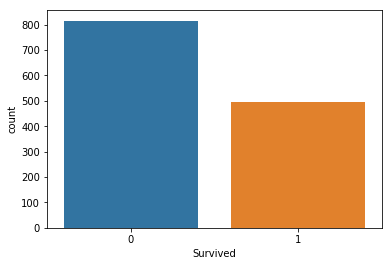

In [9]:
sb.countplot(x="Survived",data=titanic_data)

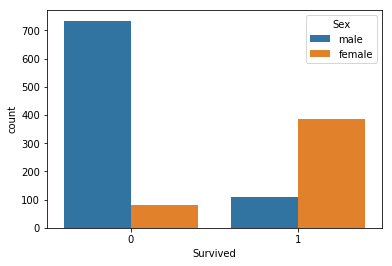

In [10]:
sb.countplot(x="Survived", hue="Sex", data=titanic_data)

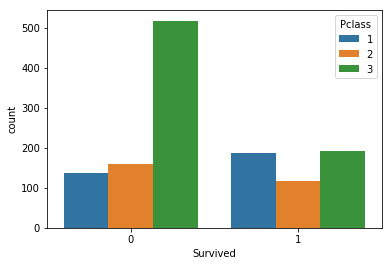

In [11]:
sb.countplot(x="Survived", hue="Pclass", data=titanic_data)

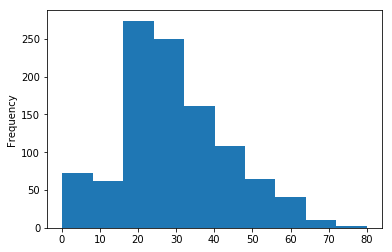

In [12]:
titanic_data["Age"].plot.hist()

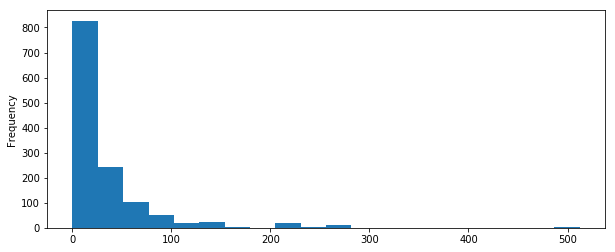

In [13]:
titanic_data["Fare"].plot.hist(bins=20, figsize=(10,4))

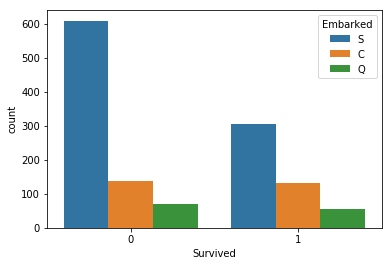

In [14]:
sb.countplot("Survived",hue="Embarked",data=titanic_data)

### Data Wrangling

In [15]:
titanic_data.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
dtype: int64

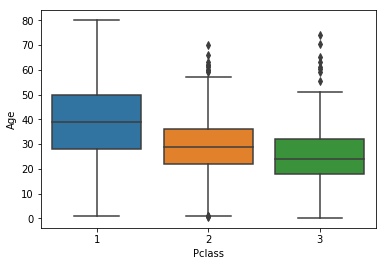

In [16]:
sb.boxplot(x="Pclass",y="Age", data=titanic_data)

In [17]:
def name_extract(word):
    return word.split(',')[1].split('.')[0].strip()

In [18]:
df_salutation=pd.DataFrame({'Salutation':titanic_data['Name'].apply(name_extract)})

In [19]:
df_salutation.head()

,Salutation
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr


In [20]:
titanic_data=pd.concat([titanic_data,df_salutation], axis=1)

In [20]:
#meanAge=np.mean(titanic_data.Age)

In [21]:
#titanic_data["Age"]=titanic_data.Age.fillna(meanAge)

In [22]:
missing_ages = titanic_data[titanic_data['Age'].isnull()]
# determine mean age based on Sex and Pclass
mean_ages = titanic_data.groupby(['Sex','Pclass'])['Age'].mean()

def remove_na_ages(df):
    if pd.isnull(df['Age']):
        return mean_ages[df['Sex'],df['Pclass']]
    else:
        return df['Age']

titanic_data['Age'] =titanic_data.apply(remove_na_ages, axis=1)

In [23]:
#Assign value 1 for passengers with cabin
titanic_data.loc[titanic_data['Cabin'].notnull(), 'Cabin'] = 1

In [24]:
#Assign value 0 for passengers without cabin
titanic_data.loc[titanic_data['Cabin'].isnull(), 'Cabin'] = 0

In [25]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,Mr


In [26]:
sex=pd.get_dummies(titanic_data["Sex"])
#sex=pd.get_dummies(titanic_data["Sex"],drop_first=True)

In [27]:
Pclass=pd.get_dummies(titanic_data["Pclass"],prefix='Pclass')
#Pclass=pd.get_dummies(titanic_data["Pclass"],drop_first=True,prefix='Pclass')

In [28]:
Embarked=pd.get_dummies(titanic_data["Embarked"], prefix='Embarked')
#Embarked=pd.get_dummies(titanic_data["Embarked"],drop_first=True, prefix='Embarked')

In [29]:
titanic_data.drop(["Pclass","Sex","Embarked","Ticket","Name"], axis=1, inplace=True)

In [30]:
titanic_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Salutation
0,1,0,22.0,1,0,7.2500,0,Mr
1,2,1,38.0,1,0,71.2833,1,Mrs
2,3,1,26.0,0,0,7.9250,0,Miss
3,4,1,35.0,1,0,53.1000,1,Mrs
4,5,0,35.0,0,0,8.0500,0,Mr


In [31]:
titanic_data=pd.concat([titanic_data,sex,Pclass,Embarked], axis=1)

In [32]:
titanic_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Salutation,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,Mr,0,1,0,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,Mrs,1,0,1,0,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,Miss,1,0,0,0,1,0,0,1
3,4,1,35.0,1,0,53.1000,1,Mrs,1,0,1,0,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,Mr,0,1,0,0,1,0,0,1


In [15]:
titanic_data.groupby('Salutation').Survived.count()

Salutation
Capt              1
Col               4
Don               1
Dona              1
Dr                8
Jonkheer          1
Lady              1
Major             2
Master           61
Miss            260
Mlle              2
Mme               1
Mr              757
Mrs             197
Ms                2
Rev               8
Sir               1
the Countess      1
Name: Survived, dtype: int64

In [34]:
def group_salutation(old_salutation):
    if(old_salutation=="Mr"):
        return "Mr"
    else:
        if(old_salutation=="Miss"):
            return "Miss"
        else:
            if(old_salutation=="Mrs"):
                return "Mrs"
            else:
                if(old_salutation=="Master"):
                    return "Master"
                else:
                    return "Others"
        

In [35]:
df_salutation=pd.DataFrame({"New_Salutation": titanic_data['Salutation'].apply(group_salutation)})

In [36]:
titanic_data=pd.concat([titanic_data,df_salutation],axis=1)

In [37]:
titanic_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Salutation,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,New_Salutation
0,1,0,22.0,1,0,7.2500,0,Mr,0,1,0,0,1,0,0,1,Mr
1,2,1,38.0,1,0,71.2833,1,Mrs,1,0,1,0,0,1,0,0,Mrs
2,3,1,26.0,0,0,7.9250,0,Miss,1,0,0,0,1,0,0,1,Miss
3,4,1,35.0,1,0,53.1000,1,Mrs,1,0,1,0,0,0,0,1,Mrs
4,5,0,35.0,0,0,8.0500,0,Mr,0,1,0,0,1,0,0,1,Mr


In [38]:
df=pd.get_dummies(titanic_data.New_Salutation)

In [39]:
titanic_data=pd.concat([titanic_data,df],axis=1)

In [40]:
titanic_data=titanic_data.drop(['Salutation','Others','New_Salutation'], axis=1)

In [41]:
titanic_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Master,Miss,Mr,Mrs
0,1,0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,1,0,0,1,0
1,2,1,38.0,1,0,71.2833,1,1,0,1,0,0,1,0,0,0,0,0,1
2,3,1,26.0,0,0,7.9250,0,1,0,0,0,1,0,0,1,0,1,0,0
3,4,1,35.0,1,0,53.1000,1,1,0,1,0,0,0,0,1,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,1,0,0,1,0


In [42]:
titanic_data.shape

(1309, 19)

In [43]:
#Split the records into train and test.
titanic_test=titanic_data.iloc[891:,]
titanic_train=titanic_data.iloc[:891,]
print(titanic_test.shape)
print(titanic_train.shape)

(418, 19)
(891, 19)


In [44]:
titanic_train=titanic_train.drop('PassengerId',axis=1)

In [45]:
titanic_test=titanic_test.drop('Survived',axis=1)

In [46]:
x=titanic_train.drop("Survived",axis=1)


In [47]:
y=titanic_train["Survived"]

In [48]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3,random_state=22)

In [57]:
x_train.head()

,Age,SibSp,Parch,Fare,Cabin,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Master,Miss,Mr,Mrs
65,25.962264,1,1,15.2458,0,0,1,0,0,1,1,0,0,1,0,0,0
319,40.000000,1,1,134.5000,1,1,0,1,0,0,1,0,0,0,0,0,1
746,16.000000,1,1,20.2500,0,0,1,0,0,1,0,0,1,0,0,1,0
499,24.000000,0,0,7.7958,0,0,1,0,0,1,0,0,1,0,0,1,0
388,25.962264,0,0,7.7292,0,0,1,0,0,1,0,1,0,0,0,1,0


In [53]:
from sklearn.linear_model import LogisticRegression
logmod=LogisticRegression()

In [54]:
logmod.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
pred=logmod.predict(x_test)

In [56]:
from sklearn.metrics import classification_report
classification_report(y_test,pred)

'             precision    recall  f1-score   support\n\n          0       0.82      0.86      0.84       164\n          1       0.76      0.71      0.74       104\n\navg / total       0.80      0.80      0.80       268\n'

In [111]:
from sklearn.metrics import confusion_matrix

In [112]:
confusion_matrix(y_test,pred)

array([[141,  23],
       [ 30,  74]], dtype=int64)

In [113]:
from sklearn.metrics import accuracy_score

In [114]:
accuracy_score(y_test,pred)

0.8022388059701493

In [115]:
from sklearn import metrics, cross_validation
logreg=LogisticRegression()
predicted = cross_validation.cross_val_predict(logreg, x, y, cv=10)
print (metrics.accuracy_score(y, predicted))
print (metrics.classification_report(y, predicted))

0.8338945005611672
             precision    recall  f1-score   support

          0       0.85      0.89      0.87       549
          1       0.80      0.75      0.78       342

avg / total       0.83      0.83      0.83       891



In [ ]:
result.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/result.csv')